In [1]:
from time import time

import numpy as np
import pandas as pd
import pygmo as pg

from spineq.data_fetcher import get_oa_shapes
from spineq.optimise import get_optimisation_inputs
from spineq.plotting import plot_optimisation_result
from spineq.utils import coverage_matrix

In [2]:
n_sensors = 20
theta = 500

population_weight = 1
workplace_weight = 0
pop_age_groups = {
    "pop_total": {"min": 0, "max": 90, "weight": 1},
    "pop_children": {"min": 0, "max": 16, "weight": 0},
    "pop_elderly": {"min": 70, "max": 90, "weight": 0},
}

## Get Input Data

In [3]:
data = get_optimisation_inputs(
    population_weight=population_weight,
    workplace_weight=workplace_weight,
    pop_age_groups=pop_age_groups,
    combine=True,
)

data.keys()

dict_keys(['oa11cd', 'oa_x', 'oa_y', 'oa_weight'])

## PyGMO: vector of 0/1s for sensor at location or not

Fails to even meet constraints. But assume it has to "learn" how to make the vector sum up to n_sensors, which seems difficult.

In [4]:
# PyGMO User Defined Problem
class population_optimisation:
    def __init__(self, oa_x, oa_y, oa_weight, n_sensors, theta):

        self.n_sensors = n_sensors
        self.oa_weight = oa_weight
        self.coverage = coverage_matrix(oa_x, oa_y, theta=theta)

        # dimension of problem = number of candidate sensor locations
        self.dim = len(oa_x)

    def fitness(self, sensors):
        """
        PyGMO required function.
        The objective function to minimise. And constraints to evaluate.
        """
        # only keep coverages due to output areas where a sensor is present
        mask_cov = np.multiply(self.coverage, sensors[np.newaxis, :])

        # coverage at each output area = coverage due to nearest sensor
        max_mask_cov = np.max(mask_cov, axis=1)

        # Total population-weighted coverage of solution = our objective
        fitness_sensors = -(self.oa_weight * max_mask_cov).sum() / self.oa_weight.sum()

        # constraint: have n_sensors sensors
        # equality constraints: must equal zero
        constraint_n_sensors = sensors.sum() - self.n_sensors

        return [fitness_sensors, constraint_n_sensors]

    def get_bounds(self):
        """
        PyGMO required function.
        Defines min and max value for each parameter.
        """
        return ([0] * self.dim, [1] * self.dim)

    def get_nec(self):
        """PyGMO function.
        Defines number of equality constraints."""
        return 1

    def get_nix(self):
        """
        PyGMO function.
        Number of integer dimensions.
        """
        return self.dim

    def gradient(self, x):
        return pg.estimate_gradient_h(lambda x: self.fitness(x), x)

In [5]:
# Build problem
pop_opt = population_optimisation(
    data["oa_x"],
    data["oa_y"],
    data["oa_weight"],
    n_sensors,
    theta,
)

prob = pg.problem(pop_opt)

print(prob)

Problem name: <class '__main__.population_optimisation'>
	C++ class name: pybind11::object

	Global dimension:			952
	Integer dimension:			952
	Fitness dimension:			2
	Number of objectives:			1
	Equality constraints dimension:		1
	Inequality constraints dimension:	0
	Tolerances on constraints: [0]
	Lower bounds: [0, 0, 0, 0, 0, ... ]
	Upper bounds: [1, 1, 1, 1, 1, ... ]
	Has batch fitness evaluation: false

	Has gradient: true
	User implemented gradient sparsity: false
	Expected gradients: 1904
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0
	Gradient evaluations: 0

	Thread safety: none



In [6]:
# Create algorithm to solve problem with
algo = pg.algorithm(uda=pg.gaco(gen=100))
algo.set_verbosity(1)
print(algo)

# population of problems
pop = pg.population(prob=prob, size=100)

Algorithm name: GACO: Ant Colony Optimization [stochastic]
	C++ class name: pagmo::gaco

	Thread safety: basic

Extra info:
	Generations: 100
	Accuracy parameter: 0.01
	Improvement stopping criterion: 100000
	Evaluation stopping criterion: 100000
	Focus parameter: 0
	Kernel: 63
	Oracle parameter: 0
	Pseudo-random number generator (Marsenne Twister 19937): 870851502 393228711 426178021 1954123868 818067893 3794280814 2578679047 1965434880 662524269 3674174730 464125335 2246564766 3125026968 3465103055 4070578826 3978086684 2278944843 1929240030 1593696269 2271465679 112858613 853395134 1477252876 3688566072 941476703 3106935700 2609709128 231651149 2445379197 1405945656 122706587 3245191750 9519705 1379913278 3494188541 3858275161 4256068774 1052987966 2982453404 1759112317 3303844116 2877097276 3704831904 2916832890 4128724356 3735747952 3443362189 2462466869 212988899 2901324736 3131948476 4182280745 2863987910 3456671113 1820000680 4161411300 1705013851 234178491 2672123905 367142410

In [7]:
# solve problem
pop = algo.evolve(pop)

print("f evals", pop.problem.get_fevals())
print("g evals", pop.problem.get_gevals())
print("champion f", pop.champion_f)
print("n_sensors", pop.champion_x.sum())
print("min sensors at location", pop.champion_x.min())
print("max sensors at location", pop.champion_x.max())

f evals 10100
g evals 0
champion f [ -0.79209616 381.        ]
n_sensors 401.0
min sensors at location 0.0
max sensors at location 1.0


In [8]:
def pygmo_result_dict(pop, data, theta):
    """Convert PyGMO optimised population into result dict
    with format needed for plot_optimisation_result.
    pop: evolved population
    data: input optimisation data from get_optimisation_inputs
    theta: coverage decay rate parameter
    """
    sensors = pop.champion_x

    coverage = coverage_matrix(data["oa_x"], data["oa_y"], theta=theta)
    mask_cov = np.multiply(coverage, sensors[np.newaxis, :])
    oa_coverage = np.max(mask_cov, axis=1)

    n_poi = len(data["oa_x"])

    sensors = [
        {"x": data["oa_x"][i], "y": data["oa_y"][i], "oa11cd": data["oa11cd"][i]}
        for i in range(n_poi)
        if sensors[i] == 1
    ]

    oa_coverage = [
        {"oa11cd": data["oa11cd"][i], "coverage": oa_coverage[i]} for i in range(n_poi)
    ]

    total_coverage = -pop.champion_f[0]

    result = {
        "sensors": sensors,
        "oa_coverage": oa_coverage,
        "total_coverage": total_coverage,
    }

    return result

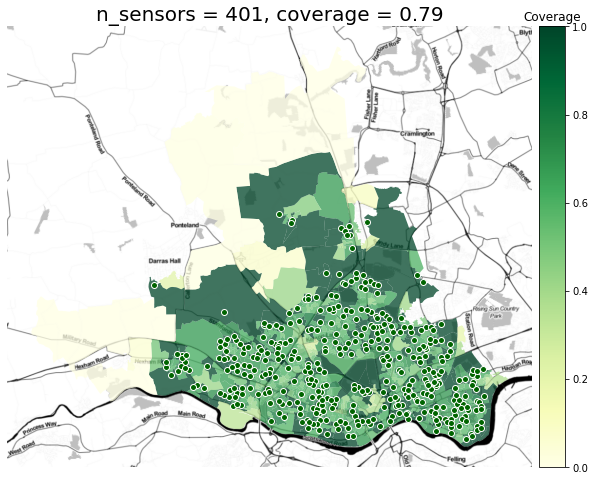

In [9]:
result = pygmo_result_dict(pop, data, theta)

plot_optimisation_result(result)

## PyGMO: Sensors at any arbitrary position (not only output area centroids)

In [10]:
# PyGMO User Defined Problem
class population_optimisation:
    def __init__(self, oa_x, oa_y, oa_weight, n_sensors, theta):

        self.n_sensors = n_sensors
        self.oa_weight = oa_weight
        self.oa_x = oa_x
        self.oa_y = oa_y
        self.theta = theta

        self.min_x = oa_x.min()
        self.min_y = oa_y.min()
        self.max_x = oa_x.max()
        self.max_y = oa_y.max()

    def fitness(self, sensors):
        """
        PyGMO required function.
        The objective function to minimise. And constraints to evaluate.
        """
        # extract sensor x and y positions
        sensors_x = sensors[0::2]
        sensors_y = sensors[1::2]

        # coverage at each output area due to each sensor
        coverage = coverage_matrix(
            sensors_x, sensors_y, self.oa_x, self.oa_y, theta=self.theta
        )

        # coverage at each output area = coverage due to nearest sensor
        max_cov = np.max(coverage, axis=0)

        # Total population-weighted coverage of solution = our objective
        fitness_sensors = -(self.oa_weight * max_cov).sum() / self.oa_weight.sum()

        return [fitness_sensors]

    def get_bounds(self):
        """
        PyGMO required function.
        Defines min and max value for each parameter.
        """
        return (
            [self.min_x, self.min_y] * self.n_sensors,
            [self.max_x, self.max_y] * self.n_sensors,
        )

    def gradient(self, x):
        return pg.estimate_gradient_h(lambda x: self.fitness(x), x)

In [11]:
# Build problem
pop_opt = population_optimisation(
    data["oa_x"],
    data["oa_y"],
    data["oa_weight"],
    n_sensors,
    theta,
)

prob = pg.problem(pop_opt)

print(prob)

Problem name: <class '__main__.population_optimisation'>
	C++ class name: pybind11::object

	Global dimension:			40
	Integer dimension:			0
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [413067, 563224, 413067, 563224, 413067, ... ]
	Upper bounds: [429850, 577386, 429850, 577386, 429850, ... ]
	Has batch fitness evaluation: false

	Has gradient: true
	User implemented gradient sparsity: false
	Expected gradients: 40
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0
	Gradient evaluations: 0

	Thread safety: none



In [12]:
# Create algorithm to solve problem with
algo = pg.algorithm(uda=pg.gaco(gen=100))
algo.set_verbosity(1)
print(algo)

# population of problems
pop = pg.population(prob=prob, size=100)

Algorithm name: GACO: Ant Colony Optimization [stochastic]
	C++ class name: pagmo::gaco

	Thread safety: basic

Extra info:
	Generations: 100
	Accuracy parameter: 0.01
	Improvement stopping criterion: 100000
	Evaluation stopping criterion: 100000
	Focus parameter: 0
	Kernel: 63
	Oracle parameter: 0
	Pseudo-random number generator (Marsenne Twister 19937): 134633228 6931389 3651493523 3016318675 1978089849 2962099293 390248577 1503056876 3613815177 552838523 3456900241 638543781 3020828965 1844986736 3273725091 3229008687 1669434476 1765653522 3079036561 3936680722 3874105033 2963892167 1304518095 2703179869 559955091 1466405144 1815191543 1709752873 4090757604 687497024 3263222878 3104083408 3882833402 1237199966 677337245 2622814996 1300223442 3651290980 487410377 1791169140 1628038481 2580498617 2110833905 4283572955 3287635812 1935842000 2994204067 48425396 3867379764 1129000164 2649899915 2608330304 485194302 3976489131 2606183038 2765047587 3502160189 2769503151 1166821499 4135051

In [13]:
# solve problem
pop = algo.evolve(pop)

print("f evals", pop.problem.get_fevals())
print("g evals", pop.problem.get_gevals())
print("champion f", pop.champion_f)
print("sensors", pop.champion_x)

f evals 10100
g evals 0
champion f [-0.22820609]
sensors [425797.72820399 565581.4633466  422375.03680607 573588.8223694
 422977.31903405 569170.29507178 426718.28042742 564241.58956272
 423823.81200323 564117.24074518 418902.78825281 565866.81357096
 427486.72199648 564702.31144842 421532.67346204 567296.65835023
 425036.07557972 568546.35793602 429629.50337653 564762.68452612
 414558.86293943 565967.55128137 426233.25002751 567219.14294416
 421365.87399981 566254.93285699 421649.11981978 570539.75549319
 422413.57082442 572754.4408735  427747.25110171 568429.14774513
 427308.15425023 566141.87835188 423730.3066231  564790.16140946
 422323.58260318 569167.87205895 425202.62855947 566298.42681538]


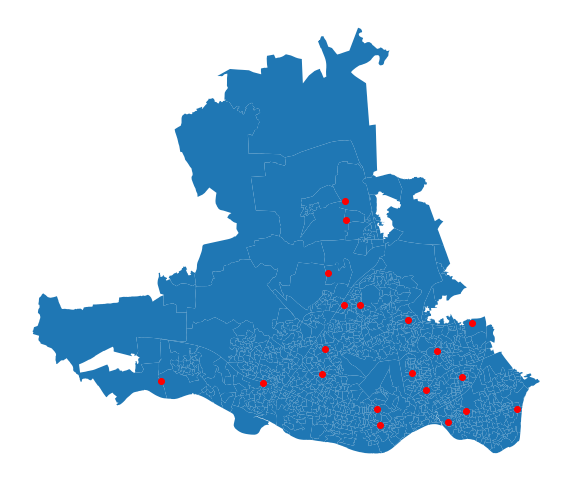

In [14]:
oa_shapes = get_oa_shapes()

ax = oa_shapes.plot(figsize=(10, 10))
ax.set_axis_off()

sensors = pop.champion_x
sensors_x = sensors[0::2]
sensors_y = sensors[1::2]
ax.scatter(sensors_x, sensors_y, color="r")

## PyGMO Sensors by Index

One decision variable for each sensor to be placed, variable value is index of location.

In [15]:
# PyGMO User Defined Problem
class population_optimisation:
    def __init__(self, oa_x, oa_y, oa_weight, n_sensors, theta):

        self.n_sensors = n_sensors
        self.n_locations = len(oa_x)
        self.oa_weight = oa_weight
        self.coverage = coverage_matrix(oa_x, oa_y, theta=theta)

    def fitness(self, sensors_idx):
        """
        PyGMO required function.
        The objective function to minimise. And constraints to evaluate.
        """
        # Construct sensors vector from indices
        sensors = np.zeros(self.n_locations)
        sensors[sensors_idx.astype(int)] = 1

        # only keep coverages due to output areas where a sensor is present
        mask_cov = np.multiply(self.coverage, sensors[np.newaxis, :])

        # coverage at each output area = coverage due to nearest sensor
        max_mask_cov = np.max(mask_cov, axis=1)

        # Total population-weighted coverage of solution = our objective
        fitness_sensors = -(self.oa_weight * max_mask_cov).sum() / self.oa_weight.sum()

        # constraint: all sensors at different locations
        # equality constraints: must equal zero
        # constraint_sensors = self.n_sensors - len(set(sensors_idx))

        return [fitness_sensors]  # , constraint_sensors]

    def get_bounds(self):
        """
        PyGMO required function.
        Defines min and max value for each parameter.
        """
        return ([0] * self.n_sensors, [self.n_locations - 1] * self.n_sensors)

    def get_nec(self):
        """PyGMO function.
        Defines number of equality constraints."""
        return 0  # 1

    def get_nix(self):
        """
        PyGMO function.
        Number of integer dimensions.
        """
        return self.n_sensors

    def gradient(self, x):
        return pg.estimate_gradient_h(lambda x: self.fitness(x), x)

In [16]:
# Build problem
pop_opt = population_optimisation(
    data["oa_x"],
    data["oa_y"],
    data["oa_weight"],
    n_sensors,
    theta,
)

prob = pg.problem(pop_opt)

print(prob)

Problem name: <class '__main__.population_optimisation'>
	C++ class name: pybind11::object

	Global dimension:			20
	Integer dimension:			20
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [0, 0, 0, 0, 0, ... ]
	Upper bounds: [951, 951, 951, 951, 951, ... ]
	Has batch fitness evaluation: false

	Has gradient: true
	User implemented gradient sparsity: false
	Expected gradients: 20
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0
	Gradient evaluations: 0

	Thread safety: none



In [17]:
# Create algorithm to solve problem with
algo = pg.algorithm(uda=pg.gaco(gen=100))
algo.set_verbosity(1)
print(algo)

# population of problems
pop = pg.population(prob=prob, size=100)

Algorithm name: GACO: Ant Colony Optimization [stochastic]
	C++ class name: pagmo::gaco

	Thread safety: basic

Extra info:
	Generations: 100
	Accuracy parameter: 0.01
	Improvement stopping criterion: 100000
	Evaluation stopping criterion: 100000
	Focus parameter: 0
	Kernel: 63
	Oracle parameter: 0
	Pseudo-random number generator (Marsenne Twister 19937): 720877084 1324602637 2257222078 3555435311 3162369120 2413606063 3414089031 3931287515 2711746624 344998931 836634249 2010572056 403817449 2822306810 1629167846 782277170 2805962698 2328422905 2421728025 1006554298 405557110 876314531 3023869541 422933946 1043201146 2207770171 2360432023 2614526180 3571839194 780871354 1538642304 2724245764 772541822 611041495 43459573 1066552524 2305128608 654658063 2485206801 4184083878 3947474753 3853154099 1482274330 1016482770 10308614 132658315 1988632069 501218243 3446583071 3794080317 3071631528 147856709 3265821037 2943731355 988691347 1659120694 2301616363 832531750 3914950200 2543315074 197

In [18]:
# solve problem
pop = algo.evolve(pop)

print("f evals", pop.problem.get_fevals())
print("g evals", pop.problem.get_gevals())
print("champion f", pop.champion_f)
print("n_sensors", pop.champion_x.sum())
print("min sensors at location", pop.champion_x.min())
print("max sensors at location", pop.champion_x.max())

f evals 10100
g evals 0
champion f [-0.29234271]
n_sensors 9934.0
min sensors at location 146.0
max sensors at location 870.0


In [19]:
def pygmo_result_dict(pop, data, theta):
    """Convert PyGMO optimised population into result dict
    with format needed for plot_optimisation_result.
    pop: evolved population
    data: input optimisation data from get_optimisation_inputs
    theta: coverage decay rate parameter
    """

    n_poi = len(data["oa_x"])

    sensors_idx = pop.champion_x

    # Construct sensors vector from indices
    sensors = np.zeros(n_poi)
    sensors[sensors_idx.astype(int)] = 1

    coverage = coverage_matrix(data["oa_x"], data["oa_y"], theta=theta)
    mask_cov = np.multiply(coverage, sensors[np.newaxis, :])
    oa_coverage = np.max(mask_cov, axis=1)

    sensors = [
        {"x": data["oa_x"][i], "y": data["oa_y"][i], "oa11cd": data["oa11cd"][i]}
        for i in range(n_poi)
        if sensors[i] == 1
    ]

    oa_coverage = [
        {"oa11cd": data["oa11cd"][i], "coverage": oa_coverage[i]} for i in range(n_poi)
    ]

    total_coverage = -pop.champion_f[0]

    result = {
        "sensors": sensors,
        "oa_coverage": oa_coverage,
        "total_coverage": total_coverage,
    }

    return result

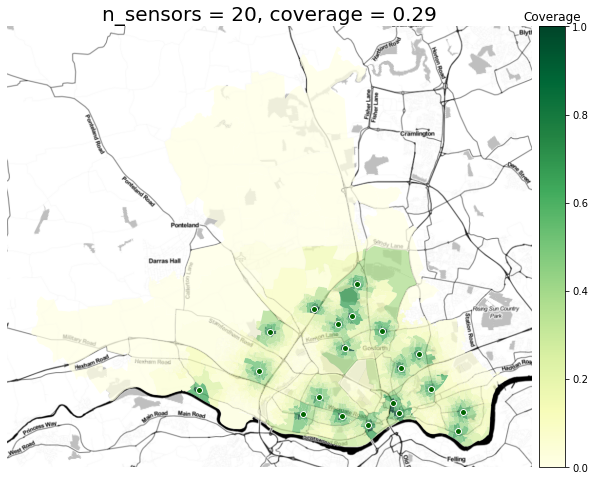

In [20]:
result = pygmo_result_dict(pop, data, theta)

plot_optimisation_result(result)

## Compare Algorithms

In [21]:
algorithms = [
    {"name": "Extended Ant Colony Optimization (GACO)", "fn": pg.gaco},
    {"name": "Differential Evolution (DE)", "fn": pg.de},
    {"name": "Self-adaptive DE (jDE and iDE)", "fn": pg.sade},
    {"name": "Self-adaptive DE (de_1220 aka pDE)", "fn": pg.de1220},
    {"name": "Grey wolf optimizer (GWO)", "fn": pg.gwo},
    {"name": "Improved Harmony Search", "fn": pg.ihs},
    {"name": "Particle Swarm Optimization (PSO)", "fn": pg.pso},
    {"name": "Particle Swarm Optimization Generational (GPSO)", "fn": pg.pso_gen},
    {"name": "(N+1)-ES Simple Evolutionary Algorithm", "fn": pg.sea},
    {"name": "Simple Genetic Algorithm", "fn": pg.sga},
    {"name": "Corana’s Simulated Annealing (SA)", "fn": pg.simulated_annealing},
    {"name": "Artificial Bee Colony (ABC)", "fn": pg.bee_colony},
    {"name": "Covariance Matrix Adaptation Evo. Strategy (CMA-ES)", "fn": pg.cmaes},
    {"name": "Exponential Evolution Strategies (xNES)", "fn": pg.xnes},
]

In [22]:
def run_opt(prob, uda, gen=100, size=100):
    start_time = time()

    # Create algorithm to solve problem with
    algo = pg.algorithm(uda=uda(gen=gen))
    algo.set_verbosity(1)

    # population of problems
    pop = pg.population(prob=prob, size=size)

    # solve problem
    pop = algo.evolve(pop)

    elapsed = time() - start_time
    score = -pop.champion_f[0]

    return score, elapsed

In [23]:
# Build problem
pop_opt = population_optimisation(
    data["oa_x"],
    data["oa_y"],
    data["oa_weight"],
    n_sensors,
    theta,
)

prob = pg.problem(pop_opt)
print(prob)
print("-" * 30)

for i, alg in enumerate(algorithms):
    print("Doing", alg["name"])
    try:
        score, elapsed = run_opt(prob, alg["fn"])
        algorithms[i]["score"] = score
        algorithms[i]["time"] = elapsed
        print("Score:", score)
        print("Time:", elapsed)
    except Exception as e:
        print(f"Error {e}")

    print("-" * 30)

Problem name: <class '__main__.population_optimisation'>
	C++ class name: pybind11::object

	Global dimension:			20
	Integer dimension:			20
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [0, 0, 0, 0, 0, ... ]
	Upper bounds: [951, 951, 951, 951, 951, ... ]
	Has batch fitness evaluation: false

	Has gradient: true
	User implemented gradient sparsity: false
	Expected gradients: 20
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0
	Gradient evaluations: 0

	Thread safety: none

------------------------------
Doing Extended Ant Colony Optimization (GACO)
Score: 0.29240775664176555
Time: 46.9745659828186
------------------------------
Doing Differential Evolution (DE)
Score: 0.30063944025223255
Time: 42.77745294570923
------------------------------
Doing Self-adaptive DE (jDE and iDE)
Score: 0.3080471666177031
Time: 42.49300503730774
----------------------------

In [24]:
df = pd.DataFrame(algorithms)

print("BEST SCORE:")
display(df.sort_values(by="score", ascending=False).head())

print("FASTEST:")
display(df.sort_values(by="time", ascending=True).head())

BEST SCORE:


,name,fn,score,time
9,Simple Genetic Algorithm,<class 'pygmo.core.sga'>,0.322678,36.513620
11,Artificial Bee Colony (ABC),<class 'pygmo.core.bee_colony'>,0.313021,85.697668
8,(N+1)-ES Simple Evolutionary Algorithm,<class 'pygmo.core.sea'>,0.308675,0.821675
3,Self-adaptive DE (de_1220 aka pDE),<class 'pygmo.core.de1220'>,0.308228,42.945375
2,Self-adaptive DE (jDE and iDE),<class 'pygmo.core.sade'>,0.308047,42.493005


FASTEST:


,name,fn,score,time
5,Improved Harmony Search,<class 'pygmo.core.ihs'>,0.272926,0.788342
8,(N+1)-ES Simple Evolutionary Algorithm,<class 'pygmo.core.sea'>,0.308675,0.821675
9,Simple Genetic Algorithm,<class 'pygmo.core.sga'>,0.322678,36.513620
7,Particle Swarm Optimization Generational (GPSO),<class 'pygmo.core.pso_gen'>,0.295916,37.331587
2,Self-adaptive DE (jDE and iDE),<class 'pygmo.core.sade'>,0.308047,42.493005


## Results
- Simple genetic algorithm (pg.sga) - generally best score 
- Simple evolutionary algorithm (pg.sea) - good score and generally fastest

## Simple Genetic Algorithm

In [25]:
# Create algorithm to solve problem with
algo = pg.algorithm(uda=pg.sga(gen=200))
algo.set_verbosity(1)
print(algo)

# population of problems
pop = pg.population(prob=prob, size=200)

Algorithm name: SGA: Genetic Algorithm [stochastic]
	C++ class name: pagmo::sga

	Thread safety: basic

Extra info:
	Number of generations: 200
	Crossover:
		Type: exponential
		Probability: 0.9
	Mutation:
		Type: polynomial
		Probability: 0.02
		Distribution index: 1
	Selection:
		Type: tournament
		Tournament size: 2
	Seed: 3719586274
	Verbosity: 1


In [26]:
# solve problem
pop = algo.evolve(pop)

print("f evals", pop.problem.get_fevals())
print("g evals", pop.problem.get_gevals())
print("champion f", pop.champion_f)
print("n_sensors", pop.champion_x.sum())
print("min sensors at location", pop.champion_x.min())
print("max sensors at location", pop.champion_x.max())

f evals 40200
g evals 0
champion f [-0.3348627]
n_sensors 6724.0
min sensors at location 10.0
max sensors at location 859.0


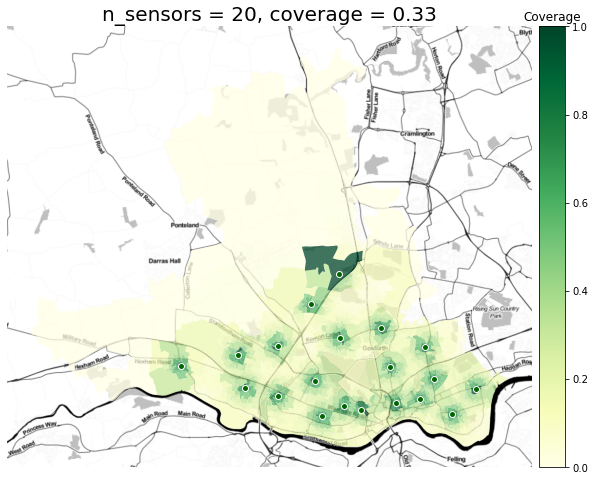

In [27]:
result = pygmo_result_dict(pop, data, theta)

plot_optimisation_result(result)

## Simple Evolutionary Algorithm

In [28]:
# Create algorithm to solve problem with
algo = pg.algorithm(uda=pg.sea(gen=20000))
algo.set_verbosity(1)
print(algo)

# population of problems
pop = pg.population(prob=prob, size=1000)

Algorithm name: SEA: (N+1)-EA Simple Evolutionary Algorithm [stochastic]
	C++ class name: pagmo::sea

	Thread safety: basic

Extra info:
	Generations: 20000
	Verbosity: 1
	Seed: 588342737


In [29]:
# solve problem
pop = algo.evolve(pop)

print("f evals", pop.problem.get_fevals())
print("g evals", pop.problem.get_gevals())
print("champion f", pop.champion_f)
print("n_sensors", pop.champion_x.sum())
print("min sensors at location", pop.champion_x.min())
print("max sensors at location", pop.champion_x.max())

f evals 21000
g evals 0
champion f [-0.33427373]
n_sensors 8245.96926399005
min sensors at location 7.05815826487383
max sensors at location 859.5782191904464


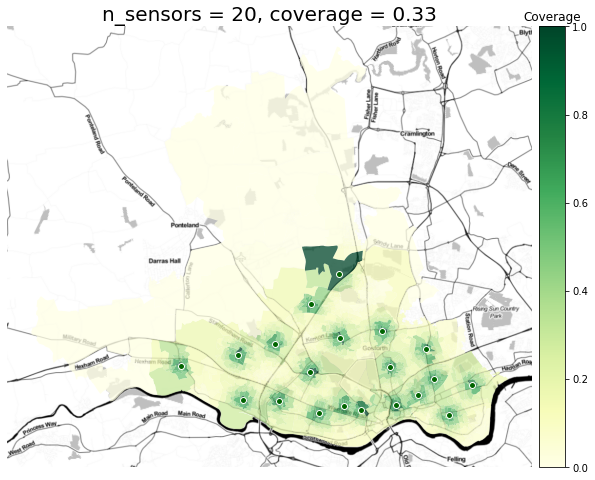

In [30]:
result = pygmo_result_dict(pop, data, theta)

plot_optimisation_result(result)